In [17]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [18]:
# load raw financial data
# hourly resolution
gamestop_data = pd.read_csv('../foobar/data/raw/stock_candle_60_2020-03-01_2021-03-01.csv')
gamestop_data = gamestop_data.sort_values(by=['timestamp_'], axis=0)
gamestop_data['timestamp_'] = pd.to_datetime(gamestop_data['timestamp_'], unit='s')
gamestop_data = gamestop_data.set_index('timestamp_')

# resmaple the data hourly and pad the gaps with the previous record
gamestop_data = gamestop_data.resample('H', label='right').pad()
print(gamestop_data.shape)

train_data = gamestop_data[gamestop_data.index.year == 2020]
short_squeeze_data = gamestop_data[gamestop_data.index.year == 2021]
print(train_data.shape)
print(short_squeeze_data.shape)
train_data.columns

(7598, 7)
(6301, 7)
(1297, 7)


Index(['Unnamed: 0', 'close_price', 'high_price', 'low_price', 'open_price',
       'status', 'volume'],
      dtype='object')

## Data Preprocessing

In [19]:
# create train and test dataset
# sorted based on timestamp 

# extract timestamps for visualization
train_datetime_list = list(train_data.index)
target_datetime_list = list(short_squeeze_data.index)
gamestop_datetime_list = list(gamestop_data.index)

# reordering the columns: put the prediction column to the last column
cols = ['open_price', 'high_price', 'low_price', 'volume', 'close_price']
df_train = train_data[cols]
df_target = short_squeeze_data[cols]
df_gamestop = gamestop_data[cols]

# check the df column types to ensure they have correct types
print(df_train.dtypes)
cols

open_price     float64
high_price     float64
low_price      float64
volume           int64
close_price    float64
dtype: object


['open_price', 'high_price', 'low_price', 'volume', 'close_price']

<AxesSubplot:xlabel='timestamp_'>

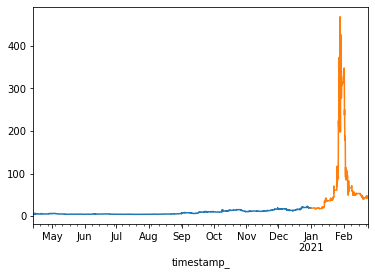

In [20]:
df_train['close_price'].plot()
df_target['close_price'].plot()

In [21]:
# finding missing values
df_train.isnull().sum()

open_price     0
high_price     0
low_price      0
volume         0
close_price    0
dtype: int64

In [22]:
df_target.isnull().sum()

open_price     0
high_price     0
low_price      0
volume         0
close_price    0
dtype: int64

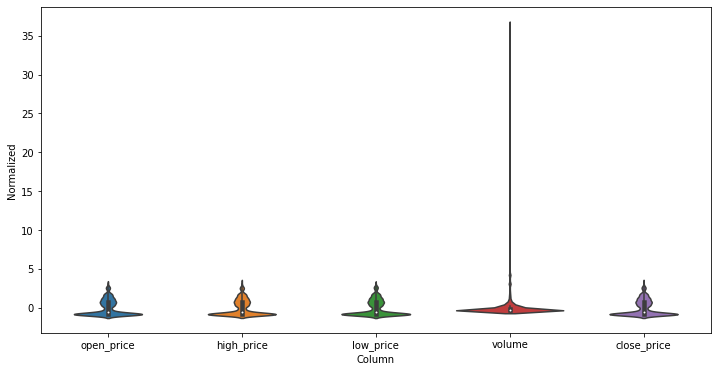

In [23]:
# Visualize the distribution of the features in the train dataset
df_std = (df_train - df_train.mean()) / df_train.std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)


In [24]:
def scale(df, feature_set, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        scaled_arr = scaler.fit_transform(df[feature_set])
    else:
        scaled_arr = scaler.transform(df[feature_set])
    return scaled_arr, scaler

def split(train_arr, train_ratio):
    # split the data to train, validate
    n = len(train_arr)
    train_set = train_arr[:int(n*train_ratio)]
    val_set = train_arr[int(n*train_ratio):]
    return train_set, val_set

### Data Windowing for time series forecasting

> Refer to [Data Windowing](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing) for more details


In [25]:
# Generate time windows for time series forecasting with LSTM network
def generate_window(dataset, train_window, pred_horizon=0):
    dataset_seq = []
    size = len(dataset)
    x_arr = []
    y_arr = []
    for i in range(size - train_window - pred_horizon):
        x = dataset[i:(i+train_window), :-1]
        y = dataset[i+train_window+pred_horizon-1:i+train_window+pred_horizon, -1]
        x_arr.append(x)
        y_arr.append(y)

    x_tensor = torch.tensor(x_arr).float()
    y_tensor = torch.tensor(y_arr).float()
    num_features = x_tensor.shape[2]
    dataset_seq = (x_tensor, y_tensor)
    return dataset_seq, num_features

def create_batch_set(dataset_seq, batch_size = 100):
    x_tensor, y_tensor = dataset_seq
    tensor_dataset = TensorDataset(x_tensor,y_tensor)
    tensor_dataloader = DataLoader(tensor_dataset, batch_size, False)
    return tensor_dataloader

In [26]:
# various feature sets for model selection
feature_set1 = ['open_price', 'high_price', 'low_price', 'volume', 'close_price']
feature_set2 = ['open_price', 'high_price', 'low_price', 'close_price']
feature_set3 = ['open_price', 'volume', 'close_price']
feature_set4 = ['volume', 'close_price']
feature_sets = [feature_set1, feature_set1, feature_set3, feature_set4]

# let's create sequential training dataset with various traning windows and prediction horizons
# given that the times series data has 1-hour resolution
# 24hours * (days)
train_window_list = 24 * np.array([5, 10, 30])
prediction_horizon_list = 24 * np.array([1, 2, 3, 5, 10])

feature_set = feature_sets[0]

train_set, train_scaler = scale(df_train, feature_set)
target_set, _ = scale(df_target, feature_set, train_scaler)
train_set , val_set = split(train_set, 0.8)


gamestop_set, _ = scale(df_gamestop, feature_set, train_scaler)

train_window = train_window_list[0]
prediction_horizon = prediction_horizon_list[0]

train_seq, num_features = generate_window(train_set, train_window, prediction_horizon)
val_seq, _ = generate_window(val_set, train_window, prediction_horizon)

train_batches = create_batch_set(train_seq)
val_batches = create_batch_set(val_seq)

target_seq, _ = generate_window(target_set, train_window, prediction_horizon)
gamestop_seq, _ = generate_window(gamestop_set, train_window, prediction_horizon)

datetime_target = target_datetime_list[train_window+prediction_horizon:]
datetime_gamestop = gamestop_datetime_list[train_window+prediction_horizon:]


In [33]:
train_set.shape

(5040, 5)

## Creating LSTM Network

In [27]:
class LSTM(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size=100, num_layers = 2, output_size=1):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.seq_len = seq_length
        
        self.hidden_state = None
        self.cell_state = None
        self.hidden = (self.hidden_state, self.cell_state)

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )

        self.linear = nn.Linear(self.hidden_size * self.seq_len, self.output_size)

    def init_hidden(self, batch_size, device):
        self.hidden_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.cell_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.hidden = (self.hidden_state, self.cell_state)

    def forward(self, x):
        batch_size = x.size(0)
        lstm_out, self.hidden = self.lstm(
                x,
                self.hidden
            )
        outputs = self.linear(lstm_out.reshape(batch_size,-1))
        return outputs


## Traning LSTM model

In [28]:
def train_model(model, device, train_batches, val_batches=None, num_epochs=200):

    learning_rate = 1e-3
    best_loss = np.Inf
    val_loss = None
    history = dict(train=[], val=[])

    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        train_losses = []
        for batch_ndx, train_batch in enumerate(train_batches):
            model.train()
            x_train, y_train = train_batch
            batch_size = x_train.size(0)
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            model.init_hidden(batch_size, device)
            outputs = model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss = loss.item()
            train_losses.append(train_loss)
            
            if val_batches is not None:
                with torch.no_grad():
                    model.eval()
                    val_losses = []
                    for _, val_batch in enumerate(val_batches):
                        x_val, y_val = val_batch
                        batch_size = x_val.size(0)
                        x_val = x_val.to(device)
                        y_val = y_val.to(device)
                        model.init_hidden(batch_size, device)
                        pred = model(x_val)
                        loss = criterion(pred, y_val)
                        val_loss = loss.item()
                        val_losses.append(val_loss)
                        if val_loss < best_loss:
                            best_loss = val_loss
                        if val_loss < 0.05:
                            break
            print(f'Batch {batch_ndx} Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        history['val'].append(np.mean(val_losses)) 
        history['train'].append(np.mean(train_losses)) 
            
            
    print(f"best validation loss = {best_loss}")        
    return model.eval(), history, best_loss

In [29]:
def visualization(history):
    plt.plot(history['train'], label="Training loss")
    plt.plot(history['val'], label="Test loss")
    plt.legend()

In [30]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model = LSTM(input_size=num_features, seq_length=train_window)
model.to(device)

model, history, best_loss = train_model(model, device, train_batches, val_batches, num_epochs=20)

31
Batch 43 Epoch 14: train loss 0.030223192647099495 val loss 0.013505280017852783
Batch 44 Epoch 14: train loss 0.006016745697706938 val loss 0.03430228680372238
Batch 45 Epoch 14: train loss 0.05391111224889755 val loss 0.02922290563583374
Batch 46 Epoch 14: train loss 0.009435692802071571 val loss 0.07907526940107346
Batch 47 Epoch 14: train loss 0.09212105721235275 val loss 0.2398960143327713
Batch 48 Epoch 14: train loss 0.1445879191160202 val loss 0.3713133633136749
Batch 0 Epoch 15: train loss 0.06573432683944702 val loss 0.46930477023124695
Batch 1 Epoch 15: train loss 0.08837343007326126 val loss 0.5165269374847412
Batch 2 Epoch 15: train loss 0.01583734340965748 val loss 0.5414769053459167
Batch 3 Epoch 15: train loss 0.027217764407396317 val loss 0.5444368124008179
Batch 4 Epoch 15: train loss 0.07059286534786224 val loss 0.5133141279220581
Batch 5 Epoch 15: train loss 0.07662398368120193 val loss 0.4484691619873047
Batch 6 Epoch 15: train loss 0.08145178109407425 val loss 

0.0029036758933216333


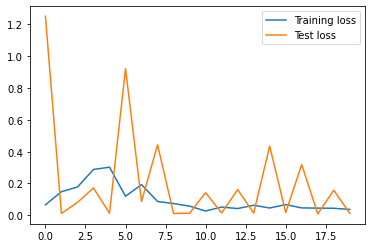

In [31]:
print(best_loss)
visualization(history)

## Predictions

In [18]:
truth, predictions, losses = [], [], []
device = torch.device("cpu")
criterion = nn.L1Loss(reduction='sum').to(device)
model.to(device)

X_test, y_test = target_seq
test_set_size = X_test.size(0)

with torch.no_grad():
    model.eval()
    for i in range(test_set_size):
        x_i = X_test[i:i+1]
        y_i = y_test[i:i+1]
        x_i.to(device)
        y_i.to(device)
        model.init_hidden(x_i.size(0), device)
        y_pred = model(x_i)
        predictions.append(y_pred.cpu().numpy().flatten())
        loss = criterion(y_pred, y_i)
        losses.append(loss.item())
        
truth = y_test.cpu().numpy().flatten()
predictions = np.array(predictions).flatten()

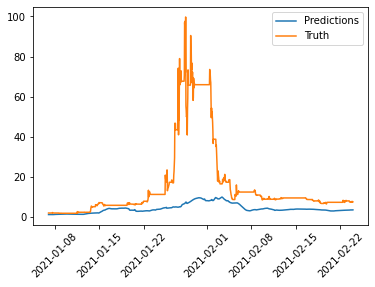

In [19]:

plt.plot(datetime_target,predictions, label="Predictions")
plt.plot(datetime_target, truth, label="Truth")
plt.xticks(rotation=45)
plt.legend()

11.497678558100645

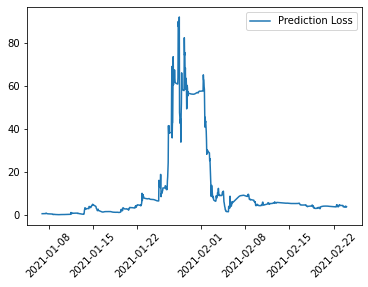

In [20]:
plt.plot(datetime_target ,losses, label="Prediction Loss")
plt.xticks(rotation=45)
plt.legend()
np.mean(losses)

In [22]:
# saving prediciton result as csv file for the entire dataset
truth, predictions, losses = [], [], []
device = torch.device("cpu")
criterion = nn.L1Loss(reduction='sum').to(device)
model.to(device)

X_test, y_test = gamestop_seq
test_set_size = X_test.size(0)

res = df_gamestop.copy()
res['predictions'] = np.nan

with torch.no_grad():
    model.eval()
    for i in range(test_set_size):
        x_i = X_test[i:i+1]
        y_i = y_test[i:i+1]
        x_i.to(device)
        y_i.to(device)
        model.init_hidden(x_i.size(0), device)
        y_pred = model(x_i)
        loss = criterion(y_pred, y_i)
        res.at[datetime_gamestop[i], 'predictions'] = y_pred.cpu().numpy().flatten()
        # res.at[datetime_gamestop[i], 'loss'] = loss.item()
        predictions.append(y_pred.cpu().numpy().flatten())
        losses.append(loss.item())
        
        
truth = y_test.cpu().numpy().flatten()
predictions = np.array(predictions).flatten()

In [23]:
res.to_csv('../foobar/data/processed/gamestop_predictions_m1.csv')

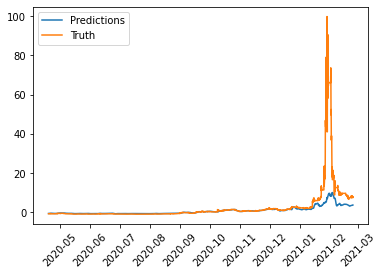

In [24]:
plt.plot(datetime_gamestop,predictions, label="Predictions")
plt.plot(datetime_gamestop, truth, label="Truth")
plt.xticks(rotation=45)
plt.legend()

In [27]:
 print('Saving...')
state = {
    'model': model.state_dict(),
    'scaler': train_scaler,
    'feature_set': feature_set,
    'history': history,
    'pred_horizon': prediction_horizon,
    'train_window': train_window
}
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
torch.save(state, f'./checkpoint/m1.pth')

Saving...


In [ ]:
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_index = 0
for train_window in train_window_list:
    for prediction_horizon in prediction_horizon_list:
        for feature_set in feature_sets:

            train_set, target_set = scale(df_train, df_target, feature_set)
            train_set , val_set = split(train_set, 0.8)

            train_seq, num_features = generate_window(train_set, train_window, prediction_horizon)
            val_seq, _ = generate_window(val_set, train_window, prediction_horizon)
            target_seq, _ = generate_window(target_set, train_window, prediction_horizon)

            datetime_target = test_datetime_list[train_window+prediction_horizon:]

            model = LSTM(input_size=num_features, seq_length=train_window)
            model = model.to(device)

            model, history = train_model(model, device, train_seq, val_seq)
            visualization(history, )
            model_index += 1

            print('Saving...')
            state = {
                'model': model,
                'feature_set': feature_set,
                'history': history,
                'pred_horizon': prediction_horizon,
                'train_window': train_window
            }

            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, f'./checkpoint/train_{model_index}.pth')
            
            
            plt.plot(history['train'], label="Training loss")
            plt.plot(history['val'], label="Test loss")
            plt.legend()

In [ ]:
def 

plt.plot(history['train'], label="Training loss")
plt.plot(history['val'], label="Test loss")
plt.legend()